# Made in collaboration with Chu Fang, Xiangdi Lin, Rachel Finley, and Dawid Cichoki

In [1]:
from transformers import BertConfig, BertTokenizerFast, BertForTokenClassification
import json
import os
import torch
from tqdm import tqdm
import random
import numpy as np
from tokenizers import Tokenizer
from torch.optim.lr_scheduler import LinearLR
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def parse_vectors(labels, outputs, parsed):
    
    #convert 2D tensor into list of vectors without padding
    ground_truth = [x[x!=-100] for x in labels]
    
    preds = []
    for idx, vec in enumerate(ground_truth):
        #for each of ground truth vectors we take the (unpadded) len to properly truncate the output vector
        unpadded_length = len(vec)
        #truncate each output vector in 2D tensor and add it to result list
        preds.append(outputs[idx][:unpadded_length])
        
    parsed['ground_truth'].extend(ground_truth)
    parsed['predictions'].extend(preds)
    
def binarize_labels(data):
    for vec in data:
        vec['bin_tags'] = [x if x !=2 else 1 for x in vec['bio_tags']] 

In [4]:
### JSON functions
def save_json(json_file, dst, sub_folder = None):
    if sub_folder:
        os.makedirs(subfolder, exist_ok = True)
        dst = subfolder + dst
    with open(dst, 'w', encoding = 'utf-8') as file:
        file.write(json.dumps(json_file))

def load_json(src):
    with open(src, encoding= 'utf-8') as file:
        return json.load(file)

### BERT Tokenizer function
def tokenize(questions, tokenizer, max_length = 100, binary=False):
    output = []
    
    split_questions = [x['question'].split() for x in questions]
    tokenized_questions = tokenizer(split_questions, is_split_into_words=True,  padding='max_length', max_length = max_length, truncation='longest_first')
    
    for idx, question in enumerate(questions):
        prev = None
        labels = []
        
        word_ids = tokenized_questions.word_ids(batch_index=idx)
        
        for idy, word_id in enumerate(word_ids):
            if word_id == None:
                labels.append(-100)
            else:
                if binary:
                    labels.append(question['bin_tags'][word_id])
                else:
                    labels.append(question['bio_tags'][word_id])

        output.append({
            'input_ids': torch.tensor(tokenized_questions.input_ids[idx], dtype=torch.int64),
            'attention_mask':  torch.tensor(tokenized_questions.attention_mask[idx], dtype=torch.bool),
            'labels': torch.tensor(labels, dtype=torch.int64),
        })
        
    return output

In [5]:
### Model settings
lr = 1e-6
batch_size = 32
num_epochs = 1
max_length = 100
model_name = "bert_ner"

### Load in edited JSON Files
data = load_json("final_set.json")
binarize_labels(data)

In [6]:
### Tokenize the data with pretrained SentencePiece tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenized = tokenize(data, tokenizer, max_length)

In [7]:
### Split data into eval set
encoded_test = tokenized[3500:]
encoded_train = tokenized[:3500]

In [9]:
### DataLoaders help batch the data for faster processing
test_data = torch.utils.data.DataLoader(encoded_test, batch_size = batch_size, shuffle = False)
train_data = torch.utils.data.DataLoader(encoded_train, batch_size = batch_size, shuffle = True)

#### Load the model and optimzer

### If you have set up GPU than the code below sets it as execution device, else its CPU
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

### Setting up basic bert model with proper max input embeddings
## set num labels to 2 to make it binary prediction task
config = BertConfig(max_position_embeddings = max_length, num_labels = 2)

### Load in our pretrained model with best loss score
model = BertForTokenClassification(config).from_pretrained("bert-base-uncased", num_labels=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
model.to(device)

results = {}

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

C:\Users\blake\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\blake\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.den

In [10]:
results = {}
results[model_name] = {'train':{}, 'test':{}}
for epoch in range(0, num_epochs):
    sum_loss = 0
    model.train()
    for batch in tqdm(train_data):
        labels = batch['labels'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(labels = labels, input_ids = input_ids, attention_mask=attention_mask)

        loss = outputs.loss
        sum_loss += loss.data.detach()

        optimizer.zero_grad()
    results[model_name]['train'][epoch] = sum_loss.item()/len(train_data)
    
    test_loss = 0
    model.eval()
    
    parsed_outputs = {'ground_truth':[], 'predictions':[]}
    
    for batch in tqdm(test_data):
        labels = batch['labels'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        with torch.no_grad():
            outputs = model(labels = labels, input_ids = input_ids, attention_mask = attention_mask)
            
            parse_vectors(labels.to('cpu'), outputs.logits.argmax(-1).to('cpu'), parsed_outputs)
            
        test_loss += outputs.loss.data.detach()
    results[model_name]['test'][epoch] = test_loss.item()/len(test_data)
    
    #model.save_pretrained(f"{model_name}_{epoch+1}ep/")
save_json(results, model_name + '_NER_accuracy.json')

100%|██████████| 32/32 [04:01<00:00,  7.56s/it]


In [11]:
results

{'bert_ner': {'train': {0: 1.2057723999023438},
  'test': {0: 1.2281886339187622}}}

In [16]:
def aggregate_errors_with_types(predictions):
    gt = predictions['ground_truth']
    pred = predictions['predictions']
    
    errors = {0:{0:0, 1:0, 2:0}, 1:{0:0, 1:0, 2:0}, 2:{0:0, 1:0, 2:0}}
    
    
    for idx, gt_vec in enumerate(gt):
        p_vec = pred[idx]
        
        for idy, gt_val in enumerate(gt_vec):
            p_val = p_vec[idy]
            
            errors[int(gt_val)][int(p_val)] += 1
    return errors

def aggregate_errors_binary(predictions):
    gt = predictions['ground_truth']
    pred = predictions['predictions']
    
    errors = {0:{0:0, 1:0}, 1:{0:0, 1:0}}
    
    
    for idx, gt_vec in enumerate(gt):
        p_vec = pred[idx]
        
        for idy, gt_val in enumerate(gt_vec):
            p_val = p_vec[idy]
            
            x = 0 if gt_val == 0 else 1
            y = 0 if p_val == 0 else 1
            
            errors[x][y] += 1
    return errors

def calculate_binary_confusion_matrix(errors):
    confusion_matrix = {}
    
    # true positive
    tp = errors[1][1]
    # true negative
    tn = errors[0][0]
    # false positive
    fp = errors[0][1]
    # false negative
    fn = errors[1][0]
    #true positive rate
    tpr = tp/(tp+fn)
    #true negative rate
    tnr = tn/(tn+fp)
    #precision
    precision = tp/(tp+fp)
    
    confusion_matrix['true_negative_rate'] = tnr
    confusion_matrix['true_positive_rate'] = tpr
    confusion_matrix['accuracy'] = (tp+tn)/(tp+tn+fp+fn)
    confusion_matrix['balanced_accuracy'] = (tpr + tnr)/2
    confusion_matrix['false_discovery_rate'] = 1-precision
    confusion_matrix['f1'] = 2*precision*tpr/(precision+tpr)
    
    return confusion_matrix

In [20]:
errors = aggregate_errors_with_types(parsed_outputs)
errors_bin = aggregate_errors_binary(parsed_outputs)

[Text(0.5, 15.0, 'Pred'), Text(33.0, 0.5, 'True')]

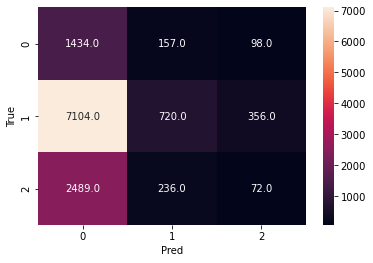

In [18]:
ax = sns.heatmap(pd.DataFrame(errors), annot=True, fmt=".1f")
ax.set(xlabel="Pred", ylabel="True")

[Text(0.5, 15.0, 'Pred'), Text(33.0, 0.5, 'True')]

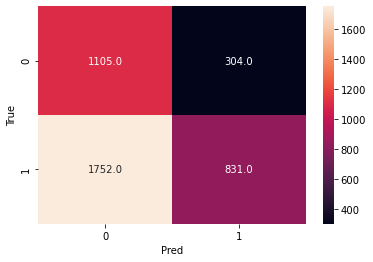

In [81]:
ax = sns.heatmap(pd.DataFrame(errors_bin), annot=True, fmt=".1f")
ax.set(xlabel="Pred", ylabel="True")

In [82]:
### Question: What if we would only train in binary fashion? Would that help our binary classification accuracy?

In [95]:
tokenized_bin = tokenize(data, tokenizer, max_length, binary = True)
### Split data into eval set
encoded_test = tokenized_bin[2000:]
encoded_train = tokenized_bin[:2000]
### DataLoaders help batch the data for faster processing
test_data = torch.utils.data.DataLoader(encoded_test, batch_size = batch_size, shuffle = False)
train_data = torch.utils.data.DataLoader(encoded_train, batch_size = batch_size, shuffle = True)
config = BertConfig(max_position_embeddings = max_length, num_labels = 2)
### Load in our pretrained model with best loss score
model = BertForTokenClassification(config).from_pretrained("bert-base-uncased", num_labels=2, local_files_only = True)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
model.to(device)

for epoch in range(0, num_epochs):
    sum_loss = 0
    model.train()
    for batch in tqdm(train_data):
        labels = batch['labels'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(labels = labels, input_ids = input_ids, attention_mask=attention_mask)
        loss = outputs.loss
        sum_loss += loss.data.detach()
        optimizer.zero_grad()
    
    test_loss = 0
    model.eval()
    parsed_outputs = {'ground_truth':[], 'predictions':[]}
    
    for batch in tqdm(test_data):
        labels = batch['labels'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        with torch.no_grad():
            outputs = model(labels = labels, input_ids = input_ids, attention_mask = attention_mask)
            parse_vectors(labels.to('cpu'), outputs.logits.argmax(-1).to('cpu'), parsed_outputs)
        test_loss += outputs.loss.data.detach()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [97]:
errors_bin_model = aggregate_errors_binary(parsed_outputs)

[Text(0.5, 15.0, 'Pred'), Text(33.0, 0.5, 'True')]

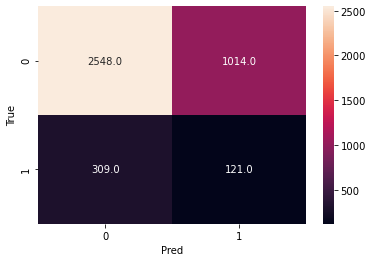

In [98]:
ax = sns.heatmap(pd.DataFrame(errors_bin_model), annot=True, fmt=".1f")
ax.set(xlabel="Pred", ylabel="True")

In [21]:
confusion_matrix = {}
confusion_matrix['non_bin_model'] = calculate_binary_confusion_matrix(errors_bin)
#confusion_matrix['bin_model'] = calculate_binary_confusion_matrix(errors_bin_model)

df = pd.DataFrame(confusion_matrix)

In [22]:
df.round(3)

,non_bin_model
accuracy,0.222
balanced_accuracy,0.487
f1,0.219
false_discovery_rate,0.874
true_negative_rate,0.130
true_positive_rate,0.844
